In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import ray
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2, feature_causal_gan
from sparse_causal_model_learner_rl.trainable.discriminator import CausalFeatureActionModelDiscriminator
from sparse_causal_model_learner_rl.trainable.fcnet import FCNet

from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL
from functools import partial

In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1.gin',
                   '../sparse_causal_model_learner_rl/configs/kc_dec.gin',
                   '../keychest/config/5x5_1f1c1k_obs.gin',
                   '../sparse_causal_model_learner_rl/configs/server_collect.gin'])

['kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1',
 'kc_dec',
 '5x5_1f1c1k_obs',
 'server_collect']

In [3]:
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.rl_multistep', [])
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.minibatch_size', 5000)
gin.bind_parameter('Config.n_collectors', 15)
gin.bind_parameter('Normalizer.type_', 'meanstd')
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', True)

In [4]:
ray.init(ignore_reinit_error=True)

2021-02-09 23:56:03,596	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '10.90.38.7',
 'raylet_ip_address': '10.90.38.7',
 'redis_address': '10.90.38.7:23350',
 'object_store_address': '/tmp/ray/session_2021-02-09_23-56-02_926418_20751/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-09_23-56-02_926418_20751/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-02-09_23-56-02_926418_20751',
 'metrics_export_port': 49117,
 'node_id': '03dd3d0d4cc690fb914c1f576acb9a6a1a78a860'}

In [5]:
gin.bind_parameter('CausalFeatureActionModelDiscriminator.input_embedder_cls',
                   {'f_t': partial(FCNet, hidden_sizes=[], activation_cls=None, add_input_batchnorm=True),
                    'f_t1': partial(FCNet, hidden_sizes=[], activation_cls=None, add_input_batchnorm=True)
                   })
gin.bind_parameter('CausalFeatureActionModelDiscriminator.feature_embedding_dim', 30)
gin.bind_parameter('CausalFeatureActionModelDiscriminator.aggregator_cls',
                   partial(FCNet, hidden_sizes=[256, 128, 64], activation_cls=torch.nn.Tanh,
                           add_input_batchnorm=True))
gin.bind_parameter('Config.causal_feature_action_model_discriminator', CausalFeatureActionModelDiscriminator)

In [6]:
# gin.bind_parameter('decoder/FCNet.hidden_sizes', [512, 256])
# gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [7]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [8]:
learner = CausalModelLearnerRL(Config(ray_kwargs={'address': '127.0.0.1:6379'}))

2021-02-09 23:56:05,863	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name fdb03f68-6b29-11eb-8ff1-90e2baa1a248
Make environment KeyChest-v0 None {}


(pid=21102) Make environment KeyChest-v0 None {}
(pid=21108) Make environment KeyChest-v0 None {}
(pid=21011) Make environment KeyChest-v0 None {}
(pid=21090) Make environment KeyChest-v0 None {}
(pid=21098) Make environment KeyChest-v0 None {}
(pid=21092) Make environment KeyChest-v0 None {}
(pid=21105) Make environment KeyChest-v0 None {}
(pid=21017) Make environment KeyChest-v0 None {}
(pid=21082) Make environment KeyChest-v0 None {}
(pid=21079) Make environment KeyChest-v0 None {}
(pid=21096) Make environment KeyChest-v0 None {}
(pid=21070) Make environment KeyChest-v0 None {}
(pid=21012) Make environment KeyChest-v0 None {}
(pid=21086) Make environment KeyChest-v0 None {}
(pid=21111) Make environment KeyChest-v0 None {}



In [9]:
learner.create_trainables()

In [10]:
learner.causal_feature_action_model_discriminator

CausalFeatureActionModelDiscriminator(
  (model_f_t): FCNet(
    (fc01): Linear(in_features=30, out_features=30, bias=True)
    (bn): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model_f_t1): FCNet(
    (fc01): Linear(in_features=32, out_features=30, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model_a_t): IdentityNet()
  (agg): FCNet(
    (fc01): Linear(in_features=64, out_features=256, bias=True)
    (fc02): Linear(in_features=256, out_features=128, bias=True)
    (fc03): Linear(in_features=128, out_features=64, bias=True)
    (fc04): Linear(in_features=64, out_features=1, bias=True)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (aggregator): FCNet(
    (fc01): Linear(in_features=64, out_features=256, bias=True)
    (fc02): Linear(in_features=256, out_features=128, bias=True)
    (fc03): Linear(in_features=128, out_features=64, bia

In [11]:
learner.model

ManyNetworkCombinedModel(
  (bn): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [12]:
learner.decoder

ModelDecoder(
  (model): FCNet(
    (fc01): Linear(in_features=847, out_features=512, bias=True)
    (fc02): Linear(in_features=512, out_features=30, bias=True)
  )
)

In [13]:
env = learner.env

In [14]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [15]:
ctx = learner.collect_and_get_context()

In [16]:
feature_causal_gan(**ctx, loss_type='generator')

{'loss': tensor(2.0826, device='cuda:0', grad_fn=<AddBackward0>),
 'metrics': {'loss_env': 0.6954656839370728,
  'loss_env_permuted': 0.6920704245567322,
  'loss_model': 0.6950871348381042,
  'mean_logits_env': -0.003470595460385084,
  'mean_logits_env_permuted': -0.003613091539591551,
  'mean_logits_model': -0.002716096118092537,
  'mse_model_pred': 2.7123842239379883}}

In [17]:
feature_causal_gan(**ctx, loss_type='discriminator')

{'loss': tensor(2.0800, device='cuda:0', grad_fn=<AddBackward0>),
 'metrics': {'loss_env': 0.6954656839370728,
  'loss_env_permuted': 0.6921154260635376,
  'loss_model': 0.6923710703849792,
  'mean_logits_env': -0.003470595460385084,
  'mean_logits_env_permuted': -0.0035864294040948153,
  'mean_logits_model': -0.002716096118092537,
  'mse_model_pred': 2.7123842239379883}}

In [18]:
features = learner.decoder(ctx['obs'])

In [19]:
f = features.detach().cpu().numpy()

In [20]:
f.shape

(5000, 30)

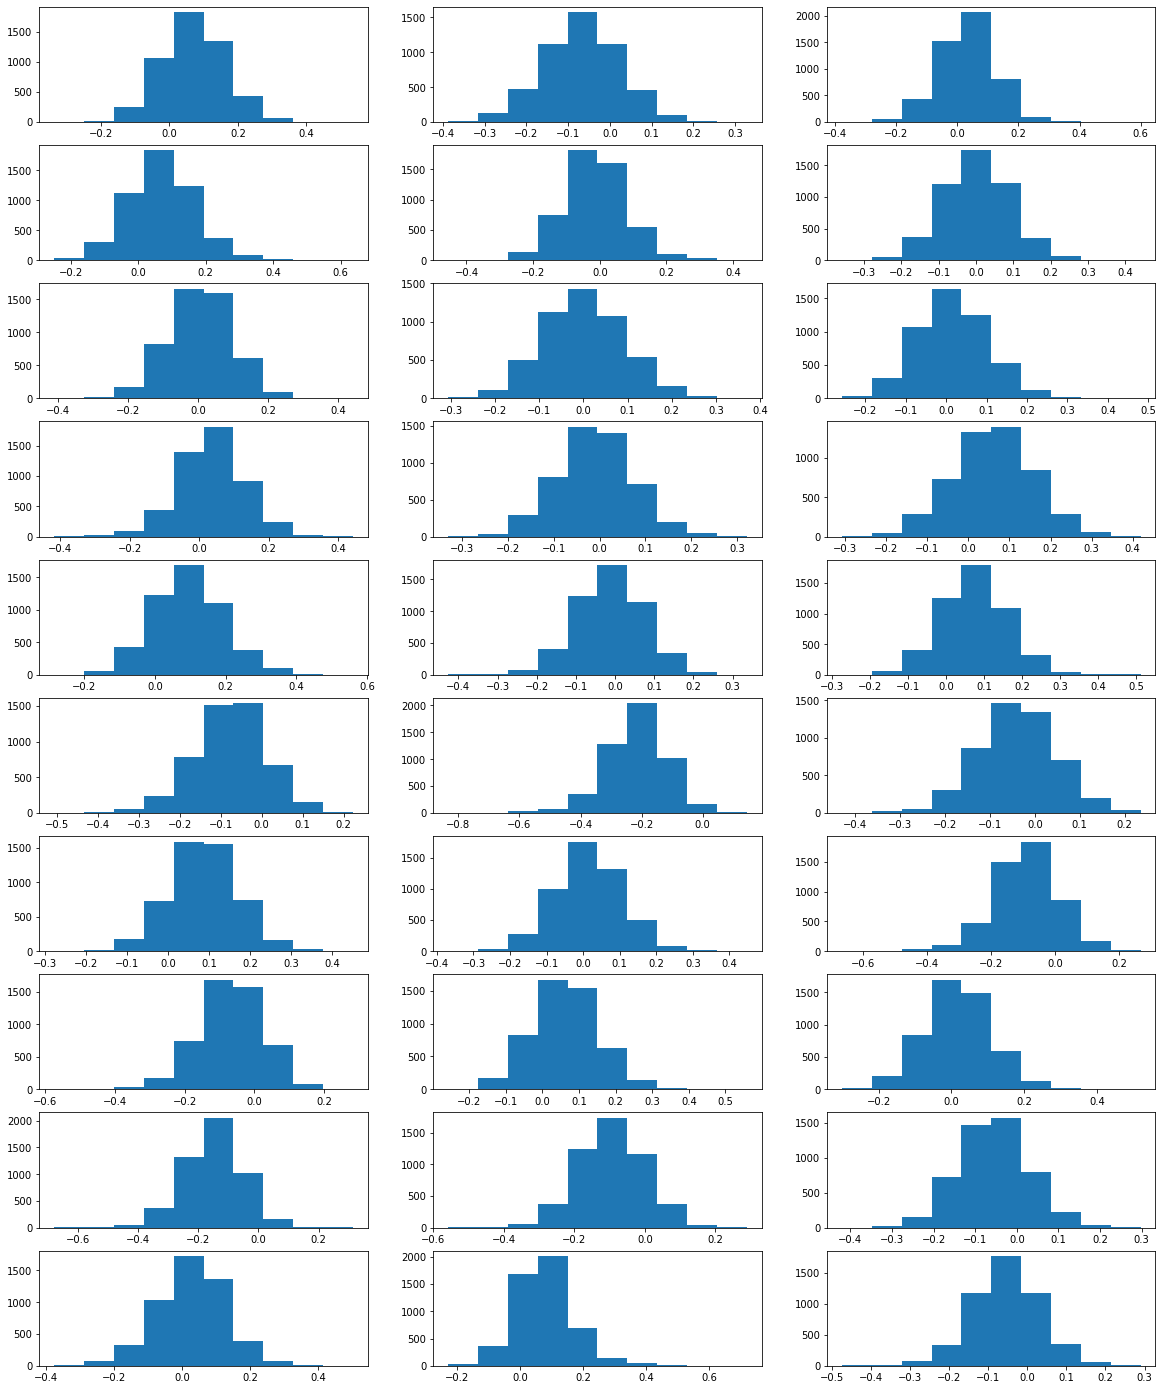

In [21]:
plt.figure(figsize=(20, 25))
for i_f in range(f.shape[1]):
    plt.subplot(10, 3, i_f + 1)
    plt.hist(f[:, i_f])

In [22]:
pd.DataFrame(f).std()

0     0.092437
1     0.092164
2     0.090026
3     0.099385
4     0.094038
5     0.089669
6     0.090847
7     0.092456
8     0.088161
9     0.097472
10    0.082431
11    0.097548
12    0.099716
13    0.085889
14    0.088518
15    0.088084
16    0.101697
17    0.087656
18    0.084432
19    0.092095
20    0.101270
21    0.094587
22    0.090868
23    0.092578
24    0.096876
25    0.094916
26    0.084950
27    0.099552
28    0.092682
29    0.088495
dtype: float32

<AxesSubplot:>

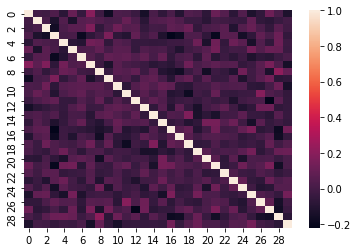

In [23]:
sns.heatmap(pd.DataFrame(f).corr())

In [24]:
env.engine.return_rgb = False

In [25]:
gin.bind_parameter('model_gnn/FCCombinedModel.activation_cls', torch.nn.Tanh)
gin.bind_parameter('model_gnn/FCCombinedModel.hidden_sizes', [100, 100, 100])
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', False)

In [26]:
learner.non_sparse_model.__init__(feature_shape=learner.feature_shape,
                                  action_shape=learner.action_shape,
                                  additional_feature_shape=learner.additional_feature_shape)
learner.non_sparse_model = learner.non_sparse_model.cuda()

In [27]:
learner.causal_feature_action_model_discriminator.__init__(observation_shape=learner.observation_shape,
                                                           action_shape=learner.action_shape,
                                                           total_feature_shape=learner.model_kwargs['total_feature_shape'],
                         feature_shape=learner.feature_shape)
learner.causal_feature_action_model_discriminator = learner.causal_feature_action_model_discriminator.cuda()

In [28]:
learner.causal_feature_action_model_discriminator

CausalFeatureActionModelDiscriminator(
  (model_f_t): FCNet(
    (fc01): Linear(in_features=30, out_features=30, bias=True)
    (bn): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model_f_t1): FCNet(
    (fc01): Linear(in_features=32, out_features=30, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model_a_t): IdentityNet()
  (agg): FCNet(
    (fc01): Linear(in_features=64, out_features=256, bias=True)
    (fc02): Linear(in_features=256, out_features=128, bias=True)
    (fc03): Linear(in_features=128, out_features=64, bias=True)
    (fc04): Linear(in_features=64, out_features=1, bias=True)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (aggregator): FCNet(
    (fc01): Linear(in_features=64, out_features=256, bias=True)
    (fc02): Linear(in_features=256, out_features=128, bias=True)
    (fc03): Linear(in_features=128, out_features=64, bia

In [29]:
learner.non_sparse_model.model.model.activation

[Tanh(), Tanh(), Tanh(), None]

In [30]:
learner.non_sparse_model

ManyNetworkCombinedModel(
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [31]:
learner.non_sparse_model.model.enable_switch

False

In [32]:
mins = None
maxes = None

In [33]:
def normalize(t, mins, maxes):
    return 2 * ((t - mins) / (1e-3 + maxes - mins) - 0.5)

In [34]:
class AdhocWorldModel(nn.Module):
    def __init__(self):
        super(AdhocWorldModel, self).__init__()
        dim = 60
        self.bn = torch.nn.BatchNorm1d(num_features=34)
        self.fc1 = nn.Linear(in_features=34, out_features=dim)
        self.fc2 = nn.Linear(in_features=dim, out_features=dim)
        self.fc3 = nn.Linear(in_features=dim, out_features=dim)
        self.fc4 = nn.Linear(in_features=dim, out_features=32)
        self.activation = nn.Tanh()
        
    def forward(self, f_t, a_t, all):
        x = torch.cat([f_t, a_t], dim=1)
        
        x = self.bn(x)
        
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        return x

In [35]:
from sparse_causal_model_learner_rl.loss.helpers import gather_additional_features


In [132]:
@gin.configurable
def feature_causal_gan(obs_x, action_x, obs_y, model, decoder,
                       additional_feature_keys,
                       causal_feature_action_model_discriminator,
                       obs_delta_eps=1e-3,
                       add_mse_coeff=None,
                       loss_type=None,
                       **kwargs):
    """GAN loss where the discriminator classifies correct/incorrect causal pairs."""
    assert loss_type in ['generator', 'discriminator', 'only_contrastive'], f"Wrong loss type {loss_type}"
    batch_dim = len(obs_x)
    device = obs_x.device

    # input features
    f_x = decoder(obs_x)

    # output features
    f_y = decoder(obs_y)
    f_y_add = gather_additional_features(additional_feature_keys=additional_feature_keys, **kwargs)
    f_y_all = torch.cat([f_y, f_y_add], dim=1)

    # permuted output features
    idxes = torch.randperm(batch_dim, device=device)
    f_y_all_permuted = f_y_all[idxes]
    obs_y_permuted = obs_y[idxes]
    act_permuted = action_x[idxes]

    # predicted features
    if loss_type == 'discriminator':
        # do not allow the decoder to break the model
        # rather, the discriminator must find issues with the model itself.
        f_x_feed = f_x.detach()
    else:
        f_x_feed = f_x
    f_y_pred = model(f_t=f_x_feed, a_t=action_x, all=True)

    logits_environment = causal_feature_action_model_discriminator(f_t=f_x, a_t=action_x, f_t1=f_y_all)
    logits_model = causal_feature_action_model_discriminator(f_t=f_x_feed, a_t=action_x, f_t1=f_y_pred)
    logits_permuted = causal_feature_action_model_discriminator(f_t=f_x, a_t=action_x, f_t1=f_y_all_permuted)

    # prediction = 1 -> correct pair
    # prediction = 0 -> incorrect pair
    env_permuted_obs_close = ((obs_y_permuted - obs_y).flatten(start_dim=1).pow(2).sum(1) +
                              (act_permuted - action_x).flatten(start_dim=1).pow(2).sum(1) <=
                              obs_delta_eps).to(device).to(torch.float32).detach()
    ans_env = torch.ones((batch_dim,), device=device, dtype=torch.float32)
    ans_env_permuted = env_permuted_obs_close  # act+obs close -> same features -> must output 1, otherwise 0

    if loss_type == 'generator':  # generator wants to have all correct pairs
        ans_model = torch.ones((batch_dim,), device=device, dtype=torch.float32)
    elif loss_type == 'discriminator':  # discriminator must see issues with the generator
        ans_model = torch.zeros((batch_dim,), device=device, dtype=torch.float32)
    elif loss_type == 'only_contrastive':
        ans_model = None
    else:
        raise ValueError(f"Wrong loss_type: {loss_type}")

    criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')

    loss_env = criterion(logits_environment.view(-1), ans_env)
    loss_env_permuted = criterion(logits_permuted.view(-1), ans_env_permuted)
    if loss_type == 'only_contrastive':
        loss_model = torch.zeros(1)
    else:
        loss_model = criterion(logits_model.view(-1), ans_model)

    mse_model_pred = (f_y_pred - f_y_all).pow(2).sum(1).mean()
    
    if loss_type == 'generator' and add_mse_coeff is not None:
        loss_model = loss_model + add_mse_coeff * mse_model_pred
        
    if loss_type == 'only_contrastive':
        loss = loss_env + loss_env_permuted
    elif loss_type == 'generator':
        loss = loss_model / 10 + loss_env + loss_env_permuted
    elif loss_type == 'discriminator':
        loss = loss_model / 10 + loss_env + loss_env_permuted 

    metrics = {
        'loss_env': loss_env.item(),
        'loss_env_permuted': loss_env_permuted.item(),
        'loss_model': loss_model.item(),
        'mean_logits_env': logits_environment.mean().item(),
        'mean_logits_env_permuted': logits_permuted.mean().item(),
        'mean_logits_model': logits_model.mean().item(),
        'mse_model_pred': mse_model_pred.item(),
    }

    return {'loss': loss,
            'metrics': metrics}

In [133]:
metrics = []
losses_gen = []
losses_disc = []
losses_dec = []
ratios = []
ctx_set = False

In [134]:
use_model = learner.non_sparse_model
#use_model = AdhocWorldModel().cuda()

In [135]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512, 256])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [136]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [144]:
opt_disc = torch.optim.Adam(lr=1e-3, params=list(learner.causal_feature_action_model_discriminator.parameters()),# + list(learner.decoder.parameters()),
                      #amsgrad=True,
                       betas=(0.5, 0.8)
                      )
opt_gen = torch.optim.Adam(lr=1e-3, params=list(use_model.parameters()), #list(learner.decoder.parameters()) + 
                      #amsgrad=True,
                       betas=(0.5, 0.8)
                      )
opt_dec = torch.optim.Adam(lr=1e-3, params=list(learner.decoder.parameters()) + list(learner.causal_feature_action_model_discriminator.parameters()),
                      #amsgrad=True,
                       betas=(0.5, 0.8)
                      )

In [145]:
[x.mean() for x in learner.decoder.state_dict().values()]

[tensor(0.0003, device='cuda:0'),
 tensor(0.0003, device='cuda:0'),
 tensor(-0.0045, device='cuda:0'),
 tensor(-0.0024, device='cuda:0'),
 tensor(-0.0005, device='cuda:0'),
 tensor(0.0002, device='cuda:0')]

In [146]:
feature_causal_gan(**ctx, loss_type='generator')

{'loss': tensor(1.3829, device='cuda:0', grad_fn=<AddBackward0>),
 'metrics': {'loss_env': 0.0010740772122517228,
  'loss_env_permuted': 0.006091786082834005,
  'loss_model': 13.75725269317627,
  'mean_logits_env': 10.428207397460938,
  'mean_logits_env_permuted': -14.860143661499023,
  'mean_logits_model': -13.749943733215332,
  'mse_model_pred': 2.9437642097473145}}

In [147]:
epochs = 500000
with tqdm(total=epochs) as pbar:
    for i in range(epochs):
        if i % 1 == 0 or not ctx_set:
            ctx_set = True
            ctx = learner.collect_and_get_context()
            ratio = ctx.get('context_stats_collected_sampled_ratio', None)
            if ratio:
                ratios.append(ratio)
            elif ratios:
                ratios.append(ratios[-1])
#             pbar.update(1)
#             continue

        ctx['non_sparse_model_add'] = use_model
        
        feature_causal_gan(**ctx, loss_type='generator')
        
        def get_loss_obj(loss_type):
            l_obj_fit = context_rewriter(function=feature_causal_gan, rewrite={'model': 'non_sparse_model_add'},
                                         **ctx,
                                         loss_type=loss_type,
                                         add_mse_coeff=1.0)
            return l_obj_fit
        
        
        l_obj_disc = get_loss_obj('discriminator')
        l_obj_gen = get_loss_obj('generator')
        l_obj_dec = get_loss_obj('only_contrastive')

        stage = (i // 50) % 3
        if stage == 0:
            # contrastive loss training
            loss = l_obj_dec['loss']
            
            opt_dec.zero_grad()
            loss.backward()
            opt_dec.step()
        elif stage == 2:
            # discriminator training
            
            loss = l_obj_disc['loss']
            
            opt_disc.zero_grad()
            loss.backward()
            opt_disc.step()
        elif stage == 1:
            # generator training
            loss = l_obj_gen['loss']
            
            opt_gen.zero_grad()
            loss.backward()
            opt_gen.step()
    
        losses_gen.append(l_obj_gen['loss'].item())
        losses_disc.append(l_obj_disc['loss'].item())
        losses_dec.append(l_obj_dec['loss'].item())
        m = {}
        m.update(l_obj_disc['metrics'])
        metrics.append(m)
        pbar.update(1)
        pbar.set_postfix(loss_gen=losses_gen[-1], loss_disc=losses_disc[-1], stage=stage, loss_dec=losses_dec[-1],
                         mse=metrics[-1]['mse_model_pred'])

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
metrics_dct = lstdct2dctlst(metrics)

# gan
plt.figure(figsize=(18, 3))
plt.subplot(1, 5, 1)
losses = np.array(losses_gen) + losses_disc
plt.plot(losses, label='tot')
plt.plot(pd.Series(losses).rolling(50).median(), label='tot')
plt.legend()
plt.yscale('log')

plt.subplot(1, 5, 2)
plt.plot(losses_gen, label='gen')
plt.plot(pd.Series(losses_gen).rolling(50).median(), label='gen')
plt.legend()
plt.yscale('log')
plt.subplot(1, 5, 3)
plt.plot(losses_disc, label='disc')
plt.plot(pd.Series(losses_disc).rolling(50).median(), label='disc')

plt.legend()
#plt.plot(dplus, label='dplus')
plt.yscale('log')

plt.subplot(1, 5, 4)
plt.plot(losses_dec, label='dec')
plt.plot(pd.Series(losses_dec).rolling(50).median(), label='dec')

plt.legend()
#plt.plot(dplus, label='dplus')
plt.yscale('log')

plt.subplot(1, 5, 5)
plt.plot(metrics_dct['mse_model_pred'], label='mse')
plt.plot(pd.Series(metrics_dct['mse_model_pred']).rolling(50).median(), label='mse')

plt.legend()
#plt.plot(dplus, label='dplus')
plt.yscale('log')

Text(0, 0.5, 'fit loss')

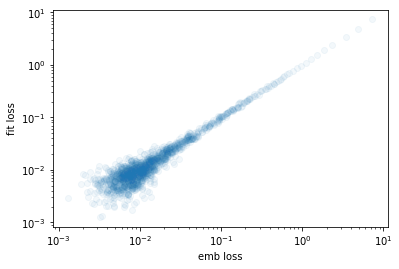

In [90]:
plt.scatter(losses_gen, losses_disc, alpha=0.05)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('emb loss')
plt.ylabel('fit loss')

In [91]:
%%javascript
var jq = document.createElement('script');
jq.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.1.4/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(jq);

<IPython.core.display.Javascript object>

In [92]:
%load_ext jupyternotify
%autonotify -a 30

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [93]:
f_t1 = learner.decoder(ctx['obs_y'])#.detach()
f_t = learner.decoder(ctx['obs_x'])#.detach()

#         f_t1 = normalize(f_t1, mins, maxes)
#         f_t = normalize(f_t, mins, maxes)

add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
# f_t1 = torch.zeros_like(f_t1)
f_t1 = torch.cat([f_t1, add_features_y], dim=1)

f_t1_pred = use_model(
f_t,
ctx['action_x'],
all=True)


<AxesSubplot:>

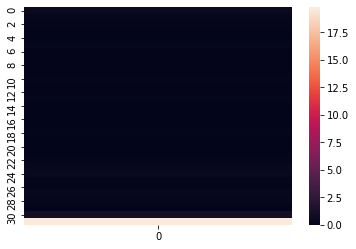

In [94]:
sns.heatmap((f_t1_pred - f_t1).pow(2).mean(0).cpu().detach().numpy().reshape(-1, 1), vmin=0)

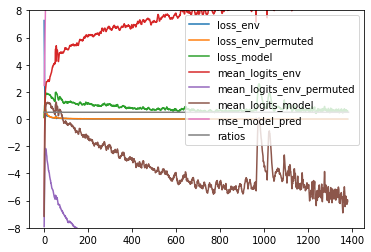

In [95]:
metrics_dct['ratios'] = ratios
for key, vals in metrics_dct.items():
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key)
plt.ylim((-8, 8))
plt.legend()
plt.show()

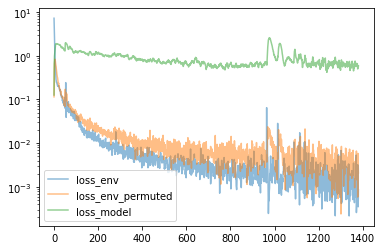

In [96]:
for key, vals in metrics_dct.items():
    if 'loss' not in key: continue
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key, alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()

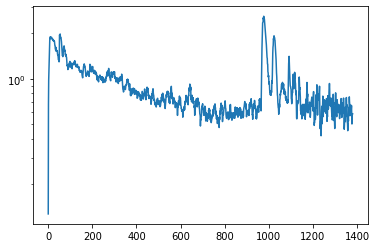

In [97]:
plt.plot(metrics_dct['loss_model'])
plt.yscale('log')

In [98]:
learner.decoder(ctx['obs_x']).min()

tensor(-3.7746, device='cuda:0', grad_fn=<MinBackward1>)

<AxesSubplot:>

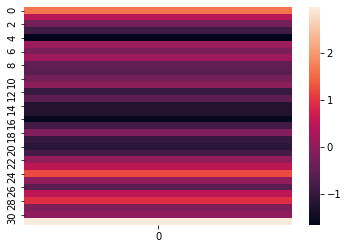

In [99]:
sns.heatmap(np.log(((f_t1_pred - f_t1).pow(2).mean(0) / f_t1.std(0).pow(2)).cpu().detach().numpy().reshape(-1, 1)))

<AxesSubplot:>

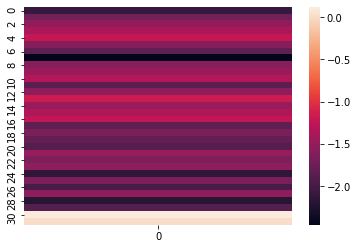

In [100]:
sns.heatmap(np.log(f_t1.std(0).pow(2).cpu().detach().numpy().reshape(-1, 1)))